In [1]:
import scipy
import scipy.io
import numpy as np
from scipy.linalg import norm
from scipy.sparse import csr_matrix
from scipy.linalg import norm
import pickle
import time
from collections import defaultdict
import json
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import pandas as pd
import numpy.matlib
import import_ipynb
import Poisson as ps
import FW
import SCOPT as sc
#import SCOPT


importing Jupyter notebook from Poisson.ipynb
importing Jupyter notebook from FW.ipynb
importing Jupyter notebook from SCOPT.ipynb


In [2]:
results = defaultdict(dict)
with open('./results/results_poisson_dict.pckl', 'rb') as f:
        results=pickle.load(f)

## Data load

In [3]:
example='a9a'
W, y = load_svmlight_file('./data/'+ example)
y = y.reshape(-1, 1)
W = W.toarray()

In [4]:
W.shape, y.shape

((32561, 123), (32561, 1))

In [5]:
#y = y.squeeze()

### Some preprocessing

In [5]:
# multiplicative multiplication of the structure of the recognizable structure
W = numpy.matlib.repmat(y, 1, W.shape[1]) * W
# summation of feature descriptions
sA = np.sum(W, 1)
# if the sum of the string is negative, invert it
W[sA < 0, :] = -W[sA < 0, :]
# zero row deletion
W = W[sA != 0, :]
# W = scipy.sparse.csr_matrix(W)

In [6]:
Bias = 1
b = (Bias * y).squeeze()
b = np.abs(b)
if (b.any == 0):
    print(' Input parameter y error')

In [7]:
y = b
y.shape
N, n = W.shape

In [8]:
N, n = W.shape
lam =  np.sqrt(N)/2
#first set of parameters
Mf = max(2/np.sqrt(y))
nu = 3
I = np.eye(n)
Iv = np.ones(n)

#running parameters
x0 = np.ones(n) / n
terminate_tol = 1e-10
M = ps.poisson(W,y,lam,x0)[0]/lam

#parameters for FW
FW_params={
    'iter_FW':50000,
    'line_search_tol':1e-10,
}


sc_params={
    #parameters for SCOPT
    'iter_SC': 1000,
    'Lest': 'estimate', #estimate L
    'use_two_phase':True,
    #FISTA parameters
    'fista_type': 'mfista',
    'fista_tol': 1e-5,
    'fista_iter': 1000,
    #Conjugate Gradient Parameters
    'conj_grad_tol':1e-2,
    'conj_grad_iter':100,
}

## Auxilary functions

In [9]:
func_x = lambda x: ps.poisson(W,y,lam,x)
grad_x = lambda x,dot_product: ps.grad_poisson(W, y, lam, x,dot_product)
grad_beta = lambda x,s,beta,dot_product,dot_product_s: ps.grad_poisson(W, y, lam, (1-beta)*x+beta*x,(1-beta)*dot_product+beta*dot_product_s)
hess_mult_x = lambda x,dot_product: ps.hess_mult(W, y, x, dot_product)
hess_mult_vec_x= lambda s,dot_product: ps.hess_mult_vec(W, y, s, dot_product)
extra_func = lambda x: W@x
linear_orcale = lambda grad: ps.linear_oracle_full_simplex(grad, M)
prox_func=lambda x,L: np.maximum(x,np.zeros(len(x))) #used for SCOPT

# Run FW

In [11]:
run_alpha_policies = ["standard","line_search","icml"]

for policy in run_alpha_policies:
    x, alpha_hist, Gap_hist, Q_hist, time_hist, grad_hist = FW.frank_wolfe(func_x,
                       grad_x,
                       grad_beta,
                       hess_mult_x,
                       extra_func,                                                    
                       Mf,
                       nu,
                       linear_orcale,                                                    
                       x0,
                       FW_params,        
                       alpha_policy=policy,                                                    
                       eps=terminate_tol, 
                       print_every=1000, 
                       debug_info=False)
    
    results[example][policy] = {
        'x': x,
        'alpha_hist': alpha_hist,
        'Gap_hist': Gap_hist,
        'Q_hist': Q_hist,
        'time_hist': time_hist,
        'grad_hist': grad_hist
    }
    

********* Algorithm starts *********
iter = 1, stepsize = 0.6666666666666666, criterion = 1.0, upper_bound=74847.9848381503, lower_bound=-202794943.749325
iter = 1000, stepsize = 0.001996007984031936, criterion = 0.001996007984031923, upper_bound=32775.29632473193, lower_bound=32356.503210620653
iter = 2000, stepsize = 0.000999000999000999, criterion = 0.0009990009990009797, upper_bound=32764.018607172788, lower_bound=32442.53517101841
iter = 3000, stepsize = 0.0006662225183211193, criterion = 0.0006662225183211301, upper_bound=32756.20965760683, lower_bound=32496.265388996184
iter = 4000, stepsize = 0.0004997501249375312, criterion = 0.0004997501249375804, upper_bound=32754.54422035398, lower_bound=32508.773738109372
iter = 5000, stepsize = 0.00039984006397441024, criterion = 0.00039984006397438785, upper_bound=32753.40010390113, lower_bound=32522.158832388315
iter = 6000, stepsize = 0.0003332222592469177, criterion = 0.00033322225924696514, upper_bound=32751.982933696643, lower_bound

## Run SCOPT

In [ ]:
 x, alpha_hist, Q_hist, time_hist, grad_hist = sc.scopt(func_x,
          grad_x,
          hess_mult_x,
          hess_mult_vec_x,
          Mf,
          nu,
          prox_func,
          x0,  
          sc_params,                                              
          eps=terminate_tol,                                              
          print_every=10)
    
results[example]['scopt'] = {
    'x': x,
    'alpha_hist': alpha_hist,
    'Gap_hist': Gap_hist,
    'Q_hist': Q_hist,
    'time_hist': time_hist,
    'grad_hist': grad_hist
}

iter =    1, stepsize = 4.406e-03, rdiff = 1.655e-01 , f = 74848



Poisson.ipynb:10: RuntimeWarning: divide by zero encountered in log
  "import scipy.io\n",


iter =   10, stepsize = 1.624e-03, rdiff = 8.464e-01 , f = 73607.6

iter =   20, stepsize = 2.004e-03, rdiff = 6.701e-01 , f = 72354.6

iter =   30, stepsize = 2.462e-03, rdiff = 5.125e-01 , f = 71087.7

iter =   40, stepsize = 2.313e-03, rdiff = 5.862e-01 , f = 69792.7

iter =   50, stepsize = 2.952e-03, rdiff = 4.329e-01 , f = 68519.6

iter =   60, stepsize = 2.843e-03, rdiff = 4.788e-01 , f = 67212.3

iter =   70, stepsize = 2.735e-03, rdiff = 5.274e-01 , f = 65923

iter =   80, stepsize = 2.628e-03, rdiff = 5.769e-01 , f = 64646.5

iter =   90, stepsize = 2.543e-03, rdiff = 6.270e-01 , f = 63379

iter =  100, stepsize = 2.484e-03, rdiff = 6.769e-01 , f = 62123.7

iter =  110, stepsize = 2.440e-03, rdiff = 7.262e-01 , f = 60882.5

iter =  120, stepsize = 2.410e-03, rdiff = 7.731e-01 , f = 59654.8

iter =  130, stepsize = 2.397e-03, rdiff = 8.171e-01 , f = 58440.7

iter =  140, stepsize = 2.396e-03, rdiff = 8.578e-01 , f = 57240.8

iter =  150, stepsize = 3.473e-03, rdiff = 5.762e-01

## Save results

In [13]:
with open('./results/results_poisson_dict.pckl', 'wb') as f:
    pickle.dump(results, f)

## Summarize

In [ ]:
print(example)

methods= ["standard","line_search","icml","scopt"]
for example in ['a9a','a5a']:
    print(example)
    for method in methods:
    
        x=results[example][method]['x']
        time_hist=results[example][method]['time_hist']
        Q_hist=results[example][method]['Q_hist']
    
        print(method)
        print("sum_x=%g,iter=%d,total_time=%3.3e,time_per_iter=%g,minimal_val=%g\n"%(sum(abs(x)),len(time_hist)-1,sum(time_hist),sum(time_hist)/(len(time_hist)-1),
            min(Q_hist)))


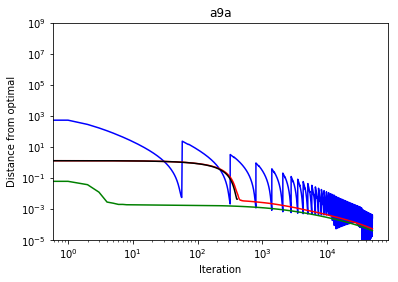

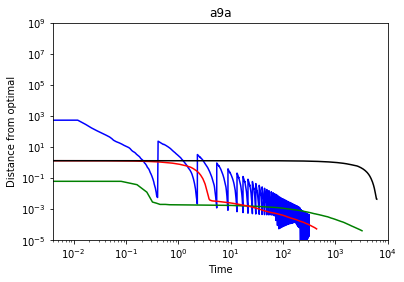

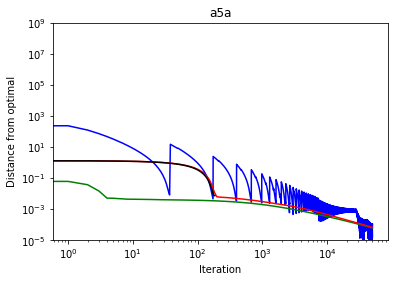

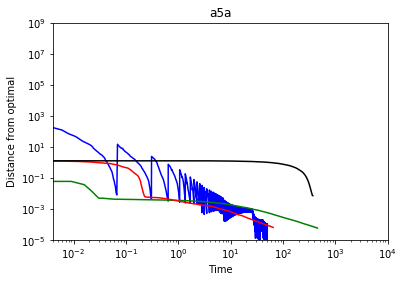

In [15]:
with open('./results/results_poisson_dict.pckl', 'rb') as f:
        results=pickle.load(f)
k=0
colors={'icml':'r','standard':'b','line_search':'g','scopt':'k'}
for example in ['a9a','a5a']:
    min_Q=1e10
    for method in methods:
        min_Q=min(min(results[example][method]['Q_hist']),min_Q)
    min_Q=min_Q-1e-10
        
    plt.figure(k)
    for method in methods:
        plt.loglog(results[example][method]['Q_hist']/min_Q-1,colors[method])
    plt.ylim((1e-5,1e+9))
    plt.xlabel('Iteration')
    plt.ylabel('Distance from optimal')
    plt.title(example)
    
    k+=1
    plt.figure(k)
    for method in methods:
        plt.loglog(np.cumsum(results[example][method]['time_hist']),results[example][method]['Q_hist']/min_Q-1,colors[method])
    plt.xlim((0.4e-2,1e+4))
    plt.ylim((1e-5,1e+9))
    plt.xlabel('Time')
    plt.ylabel('Distance from optimal')
    plt.title(example)
    k+=1